<a href="https://colab.research.google.com/github/ekirsiaed/AutoML_proj1/blob/main/AutoML_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Automated Machine Learning (LTAT.02.023)
## Course project 1
Authors:  Kristjan Laid, Mattias Väli and Evely Kirsiaed

Description:
1. Build and train a baseline, and record the result (train different machine learning algorithms with their default hyperparameters (random forest, decision tree,........etc.) and then select the one that achieves the best performance.).
2. Based on the problem at hand, you study the potential pipeline structure, algorithms, or feature transformers at each step and hyperparameter ranges. Use hyperOpt with the potential search space to beat the baseline if possible.

Assessment Criteria:
1. The project’s code should be available and ready to run if needed.
2. Everyone should understand the whole project and be ready to answer any question regarding it, not only the part they contributed to.
3. The total assessment time is 15 minutes: 10 minutes for the presentation and 5 minutes for questions.
4. You may be interrupted during the presentation for some questions.
6. Your presentation should include a dataset description, search space configurations, used baseline, selected pipeline (autoML output), overtime monitoring of the process selection, comparison between the selected and baseline pipelines, statistical test results, and justification for each step.
7. Evaluation criteria:

  a. Correctness of the code - 33% of the mark.

  b. Completeness of the presentation - 33% of the mark.

  c. Questions’ answers - 33% of the mark.

8. All team members share the same mark for a and b and might get a different mark for c, based on each student’s answers.

## Dataset description
We use the Iris dataset (see https://scikit-learn.org/1.5/datasets/toy_dataset.html)

This dataset includes 150 instances, 4 numeric attributes for each instance (sepal length, sepal width, petal length, petal width in cm) and the class (encoded as 0, 1 or 2). All three classes are equal containing 50 instances, each class refers to a type of iris plant (Iris-Setosa, Iris-Versicolour, Iris-Virginica). One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
!pip install xgboost

In [3]:
# Load the Iris dataset
data = datasets.load_iris()
X = data.data
y = data.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

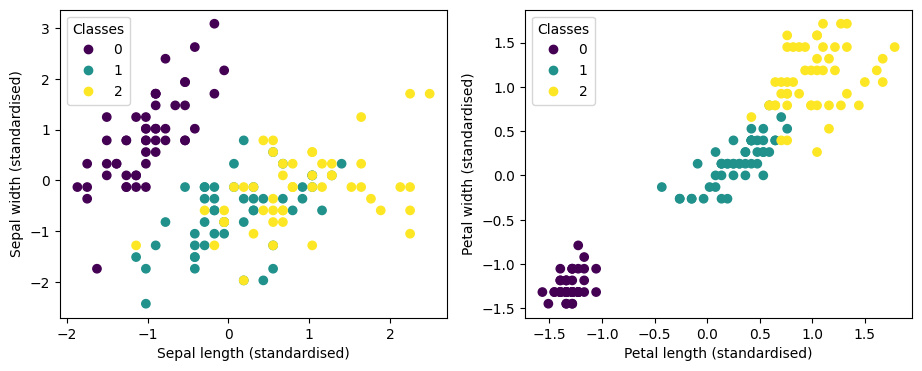

In [4]:
# Visualise attributes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(11, 4))
scatter1 = ax1.scatter(X.T[0], X.T[1],c=y, label=y)
ax1.legend(*scatter1.legend_elements(),title="Classes")
ax1.set(xlabel='Sepal length (standardised)', ylabel='Sepal width (standardised)')
scatter2 = ax2.scatter(X.T[2], X.T[3],c=y, label=y)
ax2.legend(*scatter2.legend_elements(),title="Classes")
ax2.set(xlabel='Petal length (standardised)', ylabel='Petal width (standardised)')
fig.show()

## Baseline model
For baseline model we used 11 different classifiers: GradientBoostingClassifier,
RandomForestClassifier,
XGBClassifier,
RidgeClassifier,
LogisticRegression,
GaussianNB,
BernoulliNB,
NearestCentroid,
KNeighborsClassifier,
DecisionTreeClassifier and
SVC. If possible we fixed the random state.

For quality measure we used 5-fold cross validation and mean accuracy score.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

res = dict() # save the results
for model in [GradientBoostingClassifier(random_state = 42),
              RandomForestClassifier(random_state = 42),
              XGBClassifier(random_state = 42),
              RidgeClassifier(random_state = 42),
              LogisticRegression(random_state = 42),
              GaussianNB(),
              BernoulliNB(),
              NearestCentroid(),
              KNeighborsClassifier(),
              DecisionTreeClassifier(random_state = 42),
              SVC()]:
  # Perform cross-validation and calculate the mean accuracy for each baseline model
  accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
  res[model] = accuracy

print("Mean accuracy for baseline models (ordered)")
for el in dict(sorted(res.items(), key=lambda item: item[1], reverse=True)):
  print(f"Cross-validated accuracy: {res[el]:.5f}, Model: {repr(el).split('(')[0]}")

Mean accuracy for baseline models (ordered)
Cross-validated accuracy: 0.96667, Model: RandomForestClassifier
Cross-validated accuracy: 0.96667, Model: SVC
Cross-validated accuracy: 0.96000, Model: GradientBoostingClassifier
Cross-validated accuracy: 0.96000, Model: LogisticRegression
Cross-validated accuracy: 0.96000, Model: KNeighborsClassifier
Cross-validated accuracy: 0.95333, Model: XGBClassifier
Cross-validated accuracy: 0.95333, Model: GaussianNB
Cross-validated accuracy: 0.95333, Model: DecisionTreeClassifier
Cross-validated accuracy: 0.86000, Model: NearestCentroid
Cross-validated accuracy: 0.82000, Model: RidgeClassifier
Cross-validated accuracy: 0.75333, Model: BernoulliNB


The best accuracy is obtained with Random Forest Classifier and C-Support Vector Classifier.

## Hyperparameter optimization using HyperOpt (Random Forest Classifier)
Random Forest Classifier uses the next parameters:
* n_estimators, default=100, the number of trees in the forest
* max_depth, default=None, the maximum depth of the tree
* min_samples_split, default=2, the minimum number of samples required to split an internal node
* min_samples_leaf, default=1, the minimum number of samples required to be at a leaf node
* ...

Above 4 hyperparameters are used to beat the baseline.

### Random Search

In [7]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [12]:
# Define the objective function to minimize
def objective(params):
    # Create the model using parameters from Hyperopt
    rf = RandomForestClassifier(n_estimators=int(params['n_estimators']),
                                criterion='gini',
                                max_depth=int(params['max_depth']),
                                min_samples_split=int(params['min_samples_split']),
                                min_samples_leaf=int(params['min_samples_leaf']),
                                random_state=42)

    # Compute the accuracy in cross validation
    accuracy = cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean()

    # Return a dictionary with the loss (to minimize) and status
    return {'loss': -accuracy,'status': STATUS_OK}

# Define the search space for Hyperopt
search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 250, 5)),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 150, 1)),  # Integer values between 2 and 150
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1))  # Integer values between 1 and 50
}

# Create a Trials object to store the results
trials = Trials()

# Run Hyperopt to minimize the objective function
best = fmin(fn=objective,                # Objective function
            space=search_space,          # Search space
            algo=tpe.suggest,            # Tree-structured Parzen Estimator (TPE) algorithm
            max_evals=100,               # Number of evaluations
            trials=trials,               # Store results
            rstate=np.random.default_rng(42))  # Ensure reproducibility with a fixed random seed

# Print the best hyperparameters
print("Best hyperparameters found: ", best)

100%|██████████| 100/100 [02:07<00:00,  1.27s/trial, best loss: -0.9666666666666668]
Best hyperparameters found:  {'max_depth': 130.0, 'min_samples_leaf': 1.0, 'min_samples_split': 20.0, 'n_estimators': 170.0}


As seen from best loss the baseline can not be beated. Cross-validated accuracy remains the same.

In [13]:
# Train a model with the best hyperparameters
best_rf = RandomForestClassifier(n_estimators=int(best['n_estimators']),
                                 criterion='gini',
                                 max_depth=int(best['max_depth']),
                                 min_samples_split=int(best['min_samples_split']),
                                 min_samples_leaf=int(best['min_samples_leaf']),
                                 random_state=42)

accuracy = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy') .mean()
print(f"Cross-validated accuracy: {accuracy:.5f}")

Cross-validated accuracy: 0.96667


### Grid search

In [18]:
import itertools
# Define search space taking the advantage of the results of random search
n_estimators_values = np.arange(160, 180, 5)
max_depth_values = np.arange(120, 140, 5)
min_samples_split_values = np.arange(16, 24, 2)
min_samples_leaf_values = np.arange(1, 3, 1)

grid_search_space = {
    'n_estimators': hp.choice('n_estimators', n_estimators_values),
    'max_depth': hp.choice('max_depth', max_depth_values),
    'min_samples_split': hp.choice('min_samples_split', min_samples_split_values),
    'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf_values) # Grid of fixed values
}
# Use itertools.product to find the Cartesian product (i.e., all possible combinations)
all_combinations = list(itertools.product(n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values))
total_combinations = len(all_combinations)
# Perform Grid Search using fmin
best_grid = fmin(fn=objective,        # Objective function
                 space=grid_search_space,  # Grid search space
                 algo=tpe.suggest,    # Still use TPE, but this is effectively Grid Search due to the fixed values
                 max_evals=total_combinations,       # Number of evaluations, adjust if necessary
                 rstate=np.random.default_rng(42))  # Ensure reproducibility
best_grid_rf = RandomForestClassifier(n_estimators=int(best['n_estimators']),
                                 criterion='gini',
                                 max_depth=int(best['max_depth']),
                                 min_samples_split=int(best['min_samples_split']),
                                 min_samples_leaf=int(best['min_samples_leaf']),
                                 random_state=42)


100%|██████████| 128/128 [03:01<00:00,  1.42s/trial, best loss: -0.9666666666666668]


In [19]:
accuracy = cross_val_score(best_grid_rf, X, y, cv=5, scoring='accuracy') .mean()
print(f"Cross-validated accuracy: {accuracy:.5f}")

Cross-validated accuracy: 0.96667


We did not manage to beat the baseline in case of Random Forest Classifier. Default hyperparameter values give the same mean accuracy as the best parameters found by Random Search and Grid Search (all equal to 0.96667).

## Hyperparameter optimization using HyperOpt (SVC)
SVC Classifier uses the next parameters:
* C - float, default=1.0, regularization parameter
* kernel - ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or callable, default=’rbf’, specifies the kernel type to be used in the algorithm
* gamma - ‘scale’, ‘auto’ or float, default=’scale’, kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
* ...

Above 3 hyperparameters are used to beat the baseline.

In [36]:
# Define the objective function to minimize
def objective(params):
    # Create the model using parameters from Hyperopt
    sv = SVC(C=float(params['C']),
             kernel=["rbf", "linear", "poly", "sigmoid"][int(params['kernel'])],
             gamma=float(params['gamma']),
             random_state=42)

    # Compute the accuracy in cross validation
    accuracy = cross_val_score(sv, X, y, cv=5, scoring='accuracy').mean()

    # Return a dictionary with the loss (to minimize) and status
    return {'loss': -accuracy,'status': STATUS_OK}

# Define the search space for Hyperopt
search_space = {
    'C': scope.float(hp.uniform('C', 1, 10)),
    'kernel': scope.int(hp.quniform('kernel',0,3,1)),
    'gamma': scope.float(hp.uniform('gamma', 0.0001, 10))
}

# Create a Trials object to store the results
trials = Trials()

# Run Hyperopt to minimize the objective function
best = fmin(fn=objective,                # Objective function
            space=search_space,          # Search space
            algo=tpe.suggest,            # Tree-structured Parzen Estimator (TPE) algorithm
            max_evals=500,               # Number of evaluations
            trials=trials,               # Store results
            rstate=np.random.default_rng(42))  # Ensure reproducibility with a fixed random seed

# Print the best hyperparameters
print("Best hyperparameters found: ", best)

100%|██████████| 500/500 [00:24<00:00, 20.17trial/s, best loss: -0.9866666666666667]
Best hyperparameters found:  {'C': 7.222178221165798, 'gamma': 0.11569124786677838, 'kernel': 0.0}


In [37]:
# Train a model with the best hyperparameters
best_sv = SVC(C=float(best['C']),
             kernel=["rbf", "linear", "poly", "sigmoid"][int(best['kernel'])],
             gamma=float(best['gamma']),
             random_state=42)

accuracy = cross_val_score(best_sv, X, y, cv=5, scoring='accuracy') .mean()
print(f"Cross-validated accuracy: {accuracy:.5f}")

Cross-validated accuracy: 0.98667


In case of C-Support Vector Classifier we managed to beat the baseline (cross-validated accuracy 0.96667 -> 0.986667). Since both parameters, C and gamma, are continuous the Grid Search is not appropriate method to apply. Rather we use Bayesian optimization to beat the random search accuracy.

## Bayesian optimization

In [38]:
!pip install scikit-optimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [40]:
# Define the SVM model's hyperparameter space
space = [Real(1, 10.0, "uniform", name='C'),
         Real(0.001, 10.0, "uniform", name='gamma')]

# Define the objective function to minimize
@use_named_args(space)
def objective(**params):
    # Create the SVM model with the given hyperparameters
    model = SVC(C=params['C'], gamma=params['gamma'])

    # Perform cross-validation and calculate the mean accuracy
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

    # Return the negative accuracy (because we want to minimize the objective)
    return -accuracy

# Run Bayesian optimization to find the best hyperparameters
result = gp_minimize(objective, space, n_calls=100, random_state=42)
#print(result)

# Extract the optimal hyperparameters
best_C = result.x[0]
best_gamma = result.x[1]
print(f"Optimal hyperparameters: C = {best_C}, gamma = {best_gamma}")

# Train the final model with the optimal hyperparameters
final_model = SVC(C=best_C, gamma=best_gamma)

# Evaluate the model
accuracy = cross_val_score(final_model, X, y, cv=5, scoring='accuracy').mean()
print(f"Cross-validated accuracy of the final model: {accuracy:.5f}")

Optimal hyperparameters: C = 4.118351283720701, gamma = 0.2679430026228377
Cross-validated accuracy of the final model: 0.98667


Although the hyperparameter values differ from the Random Search result, cross-validated accuracy remains the same, 0.98667.